# Chapter 62: Bagging and Boosting

### This code generates figures 3, 4, and 5 in Chapter 62: Bagging and Boosting (vol. III)


#### Runs simulations for Example 1 in the chapter


TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.


<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs.  The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Saba Nasiri. 

required libraries:
    
1. numpy
2. matplotlib.pyplot

In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Example 62.1 (Boosting a collection of threshold-based classifiers)

We illustrate the AdaBoost construction by considering the example shown in Fig. 62.3. The figure shows $N=100$ randomly generated feature vectors $h_n\in\mathbb{R}^2$ in the region $[-0.5,0.5]\times[-0.5,0.5]$ belonging to one of two classes, $\gamma\in\{\pm 1\}$ (the discs belong to class $+1$). We denote the $(x,y)-$ coordinates  of a generic feature vector $h$ by $h=[h_1\,h_2]$.

In [2]:
thres_x = np.array([-0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375]) # threshold values for x-direction
thres_y = np.array([-0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375]) # threshold values for y-direction
L = np.max(thres_x.shape) + np.max(thres_y.shape) #  number of classifiers we are using
reverse = np.ones((L, 1)) # will change value to -1 if the classifier is not weak and we need to reverse it
reverse_opt = np.ones((L, 1)) # will change value to -1 if the classifier is not weak and we need to reverse it
idx = np.zeros((L, 1))
error = np.zeros((L, 1))

# GENERATION OF DATA
N = 100

Ax = np.zeros((N, 3))
kn1 = 1
kn2 = 1

xtg = np.array([0])
ytg = np.array([0])
xtr = np.array([0])
ytr = np.array([0])

for n in range(N):
    h1 = np.random.rand() -0.5
    h2 = np.random.rand() -0.5
    
    if 0.25 <= h1 and h1 <= 0.5:
        Ax[n, :] = np.array([h1, h2, 1]) # gamma(n)=+1
        xtg = np.concatenate([xtg, Ax[n, :][0].reshape(-1,)]) # green training points
        ytg = np.concatenate([ytg, Ax[n, :][1].reshape(-1,)])
        kn1 = kn1 + 1
        
    elif -0.25 <= h1 and h1 < 0.25 and -0.5 <= h2 and h2 <= -0.25:
        Ax[n, :] = np.array([h1, h2, 1]) # gamma(n)=+1
        xtg = np.concatenate([xtg, Ax[n, :][0].reshape(-1,)]) # green training points
        ytg = np.concatenate([ytg, Ax[n, :][1].reshape(-1,)])
        kn1 = kn1 + 1
        
    elif -0.5 <= h1 and h1 <= -0.25:
        Ax[n, :] = np.array([h1, h2, -1]) # gamma(n)=-1
        xtr = np.concatenate([xtr, Ax[n, :][0].reshape(-1,)]) # red training points
        ytr = np.concatenate([ytr, Ax[n, :][1].reshape(-1,)])
        kn2 = kn2 + 1
        
    else:
        Ax[n, :] = np.array([h1, h2, -1]) # gamma(n)=-1
        xtr = np.concatenate([xtr, Ax[n, :][0].reshape(-1,)]) # red training points 
        ytr = np.concatenate([ytr, Ax[n, :][1].reshape(-1,)])
        kn2 = kn2 + 1
             
xtg = xtg[1::]
ytg = ytg[1::]
xtr = xtr[1::]
ytr = ytr[1::]

N = np.max(Ax.shape)
P = np.random.permutation(N) # randomly permuting the rows of Ax
A = np.zeros((N, 3))

for n in range(N):
    A[n, :] = Ax[P[n], :]
    
C = A[:, 2] # color map

(-0.5, 0.5)

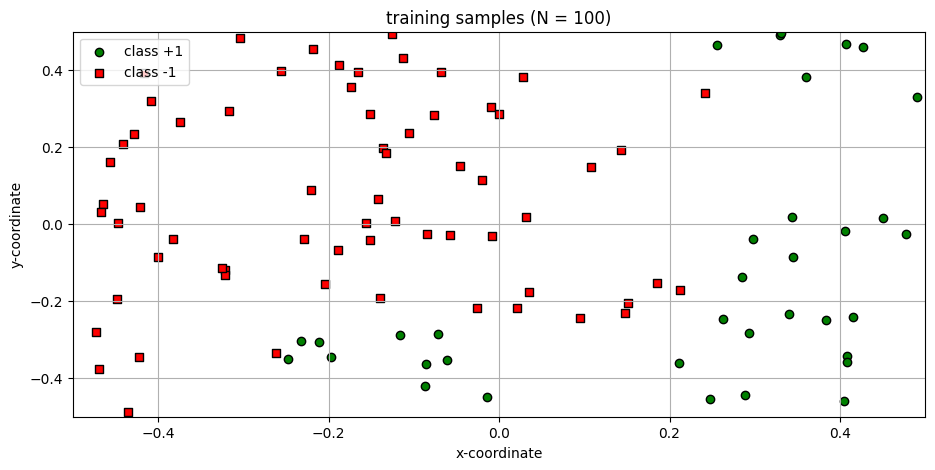

In [3]:
# figure 3 (data points)

f, axs =  plt.subplots(1, 1, figsize=(11,5))

axs.scatter(xtg, ytg, c = 'green', edgecolors='black', marker='o')
axs.scatter(xtr, ytr, c = 'red', edgecolors='black', marker='s')
axs.set_ylabel('y-coordinate')
axs.set_xlabel('x-coordinate')
axs.grid()
axs.set_title('training samples (N = 100)')
axs.legend(['class +1', 'class -1']);
axs.set_xlim([-0.5, 0.5])
axs.set_ylim([-0.5, 0.5])

#plt.savefig('fig 62.3.pdf')

**Figure 62.3** The plot shows  $=100$ training feature vectors used to construct an AdaBoost classifier.

Our objective is to build an aggregate classifier that enhances the performance of a
collection of $L=14$ weak classifiers. These latter classifiers are chosen to be threshold-based, i.e., they focus on individual $x$ or $y$ coordinates of the feature vector and decide on whether the sample belongs to one class or another by comparing the coordinate against some threshold values. The thresholds used by the $x-$ and $y-$domain classifiers are given by:

$$
\begin{align*} &
\theta_x\;\in\{-0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375\} \tag{62.23a} \\ &
\theta_y\;\in\{-0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375\} \tag{62.23b}
\end{align*}
$$

We therefore have seven $x-$ domain classifiers (denoted by $\{c_1(h),\ldots,c_7(h)\}$) and seven $y-$ domain classifiers (denoted by $\{c_8(h),\ldots,c_{14}(h)\}$). The classifiers discriminate the data according to the following rules:

$$
x \textnormal{-axis thresholds}\;\longrightarrow \left\{\begin{array}{lcl}c_1(h) = -\textnormal{sign}(h_1+0.375)\\
c_2(h) = \textnormal{ sign}(h_1+0.25)\\
c_3(h) = \textnormal{ sign}(h_1+0.125)\\
c_4(h) = \textnormal{ sign}(h_1)\\
c_5(h) = \textnormal{ sign}(h_1-0.125)\\
c_6(h) = \textnormal{ sign}(h_1-0.25)\\
c_7(h) = \textnormal{ sign}(h_1-0.375)
\end{array}\right. \tag{62.24a}
$$

and

$$
y \textnormal{-axis thresholds}\;\longrightarrow \left\{\begin{array}{lcl}c_8(h) = -\textnormal{ sign}(h_2+0.375)\\
c_9(h) = -\textnormal{ sign}(h_2+0.25)\\
c_{10}(h) = -\textnormal{ sign}(h_2+0.125)\\
c_{11}(h) = -\textnormal{ sign}(h_2)\\
c_{12}(h) = -\textnormal{ sign}(h_2-0.125)\\
c_{13}(h) = \textnormal{ sign}(h_2-0.25)\\
c_{14}(h) = \textnormal{ sign}(h_2-0.375)
\end{array}\right. \tag{62.24b}
$$

For example, classifier $c_1(h)$ decides in favor of $\gamma(h)=-1$ if $h_1\geq -0.375$ and in favor of $\gamma(h)=+1$ if $h_1<-0.375$. Note the minus sign in the definition of $c_1(h)$; the minus signs are included for various classifiers to ensure that they result in weak classifiers for this example --- see the second column of Table 62.1.

The first step of the boosting implementation involves running these classifiers on the training data. We evaluate both their empirical error rates, $R_{\textnormal{emp}}(c_{\ell})$, and their weighted empirical errors, $E(\ell)$. The results for this first step are shown in Table 62.1. It is seen that classifier $c_6(h)$ results in the smallest weighted error, $E(\ell)$, and, therefore, the first selection is:

$$
c_1^{\star}(h)=c_6(h),\;\;\;\;\alpha^{\star}(1)=1.099 \tag{62.25}
$$

**Table 62.1** Empirical error rates and weighted errors after the first iteration, t=1.}

$$
\begin{array}{c|c|c}
\textnormal{Classifier, } c_l(h) & \textnormal{Empirical error rate } (\%), R_{\textnormal{emp}}(c) & \textnormal{Weighted error}, E(l) \\ 
c_1(h) & 45\% & 0.4500 \\
c_2(h) & 41\% & 0.4100 \\
c_3(h) & 40\% & 0.4000\\
c_4(h) & 34\% & 0.3400 \\
c_5(h) & 18\% & 0.1800 \\
\boldsymbol{c_6(h)} & \boldsymbol{10}\% & \boldsymbol{0.1000} \\
c_7(h) & 21\% & 0.2100 \\
c_8(h) & 26\% & 0.2600 \\
c_9(h) & 24\% & 0.2400 \\
c_{10}(h) & 32\% & 0.3200 \\
c_{11}(h) & 42\% & 0.4200 \\
c_{12}(h) & 49\% & 0.4900 \\
c_{13}(h) & 48\% & 0.4800 \\
c_{14}(h) & 41\% & 0.4100 
\end{array} \;\;
$$

The weighting factors, $\{d_n(t)\}$, are now adjusted according to (62.17a) and the procedure is repeated. During the second step, we evaluate the weighted empirical errors, $E(\ell)$. The results for this second step are shown in Table 62.2. It is seen that classifier $c_9(h)$ now results in the smallest weighted error, $E(\ell)$, and, therefore, the second selection is:


**Table 62.2** Weighted empirical errors after the second iteration, t=2.}


$$
\begin{array}{c|c|c}
\textnormal{Classifier, } c_l(h) & \textnormal{Weighted error}, E(l) \\ 
c_1(h) & 0.6944 \\
c_2(h) & 0.2278 \\
c_3(h) & 0.4000\\
c_4(h) & 0.5444 \\
c_5(h) & 0.4556 \\
c_6(h) & 0.5000 \\
c_7(h) & 0.5611 \\
c_8(h) & 0.2333 \\
\boldsymbol{c_9(h)} & \boldsymbol{0.1333} \\
c_{10}(h) & 0.1778 \\
c_{11}(h) & 0.2333 \\
c_{12}(h) & 0.2722 \\
c_{13}(h) & 0.7111 \\
c_{14}(h) & 0.6722 
\end{array} \;\;
$$

Continuing in this manner, we arrive at the list of optimal selections $\{c^{\star}_t(h)\}$ shown in
Table 62.3 along with their weighting factors. The aggregate classifier is subsequently constructed as

$$
c^{\star}(h)\;\overset{\Delta}{=}\;\textnormal{ sign}\left(\sum_{t=1}^{L} \alpha^{\star}(t) c_t^{\star}(h)\right) \tag{62.27}
$$

The table also lists the original weak classifiers that correspond to the various optimal choices, $\{c^{\star}_t(h)\}$. It is seen in this example that the solution (62.27) depends exclusively on classifiers
$\{c_2(h),c_6(h),c_9(h)\}$. If we add the corresponding weighting coefficients, we can simplify expression (62.27) to the following form:

$$
c^{\star}(h)\;\overset{\Delta}{=}\;\textnormal{ sign}\Bigl( 3.1523\, c_2(h)\;+\;4.0976\, c_6(h)\;+\;3.9012\, c_9(h)\Bigr) \tag{62.28}
$$

If we now apply this classifier to a fine grid over the region $[-0.5,0.5]\times[-0.5,0.5]$, we obtain the colored regions shown in Fig. 62.4: the light color corresponds to class $\gamma=+1$, and the darker color corresponds to class $\gamma=-1$. The resulting empirical error for this classifier on the training data is found to be zero. Figure 62.5 shows the discrimination regions for the three classifiers
$\{c_2(h),c_6(h),c_9(h)\}$ that were selected by the boosting procedure. The blue areas indicate the regions that correspond to class $+1$ for each classifier; the regions corresponding to class $-1$ are left uncolored.

**Table 62.3** Optimal classifier selections at the successive $t=1,2,\ldots$,14 steps with the corresponding weight factors, $\alpha^{\star}(t)$
$$
\begin{array}{c|c|c}
\textnormal{Classifier } c_l^\star(h) & \textnormal{Empirical error rate } (\%), R_{\textnormal{emp}}(c) & \textnormal{Original classifier}, E(l) \\ 
c_1^{\star}(t) & 1.0986  & c_6(h)\\
c_2^{\star}(t) & 0.9395  & c_9(h)\\
c_3^{\star}(t) & 0.9443 & c_2(h)\\
c_4^{\star}(t) & 0.8069  & c_6(h)\\
c_5^{\star}(t) & 0.7838  & c_9(h)\\
c_6^{\star}(t) & 0.7543  & c_2(h)\\
c_7^{\star}(t) & 0.7431  & c_6(h)\\
c_8^{\star}(t) & 0.7342  & c_9(h)\\
c_9^{\star}(t) & 0.7296  & c_2(h)\\
c_{10}^{\star}(t) & 0.7265  & c_6(h)\\
c_{11}^{\star}(t) & 0.7248  & c_9(h)\\
c_{12}^{\star}(t) & 0.7236  & c_2(h)\\
c_{13}^{\star}(t) & 0.7229  & c_6(h)\\
c_{14}^{\star}(t) & 0.7225  & c_9(h)
\end{array} \;\;
$$

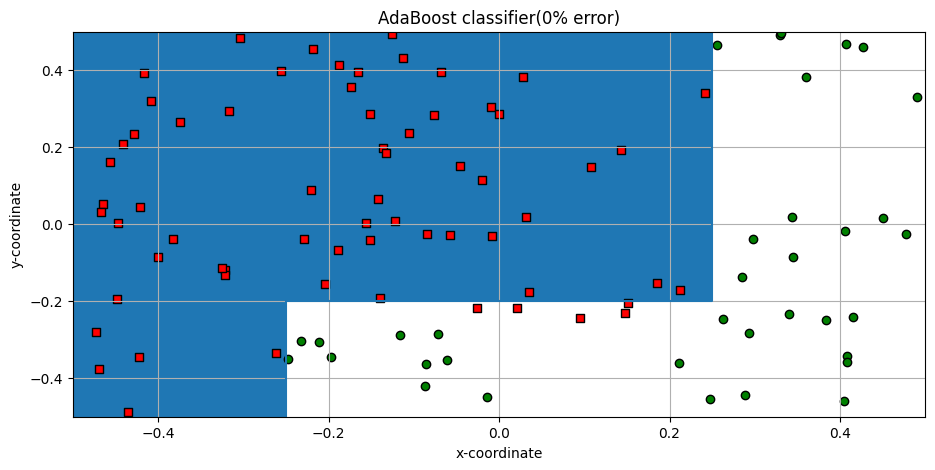

In [4]:
# figure 4

f, axs =  plt.subplots(1, 1, figsize=(11,5))

x = [-0.5, -0.25, -0.25, 0.25, 0.25]
y = [-0.6, -0.6, -0.2, -0.2, 0.5]
axs.plot(x, y)
yy = [0.5, 0.5, 0.5, 0.5, 0.5]
axs.fill_between(x, y, yy)
axs.scatter(xtg, ytg, c = 'green', edgecolors='black', marker='o')
axs.scatter(xtr, ytr, c = 'red', edgecolors='black', marker='s')
axs.set_ylabel('y-coordinate')
axs.set_xlabel('x-coordinate')
axs.grid()
axs.set_xlim([-0.5, 0.5])
axs.set_ylim([-0.5, 0.5])
axs.set_title('AdaBoost classifier(0% error)');

# plt.savefig('fig 62.4.pdf')

**Figure 62.4** The plot shows the resulting discrimination region for the AdaBoost implementation that is obtained from examining $L=14$ weak classifiers chosen to be threshold-based. These classifiers focus on individual coordinates of the feature vectors and decide on whether a feature vector belongs to one class or another by examining whether the $x-$ or $y-$ coordinate exceeds some threshold value or not.

In [5]:
# CHECKING WHETHER THE CLASSIFIERS ARE WEAK; IF ANY IS NOT WEAK
# WE REVERSE ITS CLASS DECISION

N_train = N
num = np.zeros((L,)) # saves number of errors for each classifier
num_percent = np.zeros((L,))
gamma_hat = np.zeros((N, L)) # each column contains the gamma estimates for each classifier
error = np.zeros((L,)) # counting weighted errors for each classifier
 
for n in range(N_train):
    for ell in np.arange(0, int(L/2), 1): # x-axis first
        if A[n, 0] >= thres_x[ell]:
            gamma_hat[n, ell] = 1
        else:
            gamma_hat[n, ell] = -1
            
        if A[n, 2]*gamma_hat[n, ell] <= 0: # errorneous decision
            num[ell] = num[ell] + 1 # number of errors
            
    for ell in np.arange(0, int(L/2), 1): #  y-axis first
        if A[n, 1] >= thres_y[ell]:
            gamma_hat[n, ell+int(L/2)] = 1
        else:
            gamma_hat[n, ell+int(L/2)] = -1
            
        if A[n, 2]*gamma_hat[n, ell+int(L/2)] <= 0: # errorneous decision
            num[ell+int(L/2)] = num[ell+int(L/2)] + 1 # number of errors
            

for ell in range(L):
    num_percent[ell] = (num[ell]/N_train) * 100
    if num_percent[ell] >= 50:
        reverse[ell] = -1 # we need to reverse the decision of the classifier to make it weak
    
    
print('Which classifiers need to be reversed to become weak')
print(np.concatenate([np.arange(1, L+1).reshape(-1, 1),reverse], axis = 1))


Which classifiers need to be reversed to become weak
[[ 1.  1.]
 [ 2.  1.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  1.]
 [ 7.  1.]
 [ 8. -1.]
 [ 9. -1.]
 [10. -1.]
 [11. -1.]
 [12. -1.]
 [13.  1.]
 [14.  1.]]


In [ ]:
# WE NOW INITIATE THE BOOSTING OPERATION

d = (1/N_train)*np.ones((N_train,)) # equal weights initially
gamma_opt = np.zeros((N, L)) # each column contains the gamma estimates for each optimal classifier
num_percent_opt = np.zeros((L,)) # error of optimal classifier
threshold = np.zeros((L,))
direction = []
alpha = np.zeros((L,))


for t in range(L):
# repeat L times
# we run each classifier on the data and find its error and pick
# the best and repeat    

    num = np.zeros((L,)) # saves number of errors for each classifier
    num_percent = np.zeros((L,))
    gamma_hat = np.zeros((N, L)) # each column contains the gamma estimates for each classifier
    error = np.zeros((L,)) # counting weighted errors for each classifier
    for n in range(N_train):
        for ell in range(int(L/2)): # x-axis first
            if A[n, 0] >= thres_x[ell]:
                gamma_hat[n, ell] = +1*reverse[ell]
            else:
                gamma_hat[n, ell] = -1*reverse[ell]
                
            if A[n, 2]*gamma_hat[n, ell] <= 0: # errorneous decision
                num[ell] = num[ell] + 1 # number of errors
                error[ell] = error[ell] + d[n] # weighted error
        
        for ell in range(int(L/2)): #  y-axis first
            if A[n, 1] >= thres_y[ell]:
                gamma_hat[n, ell+int(L/2)] = +1*reverse[ell+int(L/2)]
            else:
                gamma_hat[n, ell+int(L/2)] = -1*reverse[ell+int(L/2)]
            
            if A[n, 2]*gamma_hat[n, ell+int(L/2)] <= 0: # errorneous decision
                num[ell+int(L/2)] = num[ell+int(L/2)] + 1 # number of errors
                error[ell+int(L/2)] = error[ell+int(L/2)] + d[n] # weighted error
    
    for ell in range(L):
        num_percent[ell] = (num[ell]/N_train)*100 # percentage of errors on training data
        
    er = np.min(error) # find the classifier with smallest weighted error and collect its statistics
    ind = np.argmin(error)
    
    if (0.5-10**(-6)) <= er and er <= (0.5+10**(-6)): # if error is essentially 0.5, we ignore this case since the algorithm stops learning
        if ind == 0:
            error2 = error[1:L]
            er = np.min(error2)
            ind = np.argmin(error2)
            ind = ind + 1
        
        if ind == L-1:
            error2 = error[0:L-1]
            er = np.min(error2)
            ind = np.argmin(error2)
            
        if ind>0 and ind < L-1:
            error2 = np.concatenate([error[0:ind], error[ind+1:L]]) ###
            er = np.min(error2)
            ind2 = np.argmin(error2)
            if ind2 >= ind:
                ind = ind+1
            else:
                ind = ind2
    idx[t] = ind
    alpha[t] = 0.5*np.log((1-er)/er)
    gamma_opt[:, t] = gamma_hat[:, ind]
    num_percent_opt[t] = num_percent[ind]
    reverse_opt[t] = reverse[ind]
    
    for n in range(N_train):
        d[n] = d[n] * np.exp(-alpha[t]*A[n,2]*gamma_opt[n,t])
        
    d = d/np.sum(d)
    
    print(f'Results after iteration t={t}')
    print('Percentage (1st col) and weighted (2nd col) errors by all individual classifiers on training data'); 
    print(np.concatenate([np.arange(1, L+1).reshape(-1, 1), num_percent.reshape(-1, 1), error.reshape(-1, 1)], axis = 1)) #
 
    ss = idx[t]
    aa = alpha[t]
    bb = num_percent_opt[t]
    xx = reverse_opt[t]
    
    print(f'Index of best classifier for this iteration is t={ss[0]}');
    print(f'Its alpha value is t={aa}');
    print(f'Its error rate (%) on training data is bb={bb}');
    print(f'Its DECISION needs to be reversed{xx}');
    
    if ss > int(L/2)-1:
        cc = thres_y[int(ss[0])-(int(L/2)-1)]
        threshold[t] = cc
        direction.append('x')
        print(f'optimal classifier is along y-direction with threshold ={cc}');
    else:
        cc = thres_x[int(ss[0])]
        threshold[t] = cc
        direction.append('y')
        print(f'optimal classifier is along x-direction with threshold ={cc}');
    

In [ ]:
# DETERMINING PERFORMANCE OF AGGREGATE CLASSIFIER

g_class = np.zeros((N,))
num_overall = 0
g_class = np.zeros((N_train,))

for n in range(N_train):
    g_hat = 0
    for t in range(L):
        g_hat = g_hat + alpha[t] * gamma_opt[n, t]
        
    if g_hat >= 0:
        g_class[n] = 1
    else:
        g_class[n] = -1
       
    if A[n, 2]*g_class[n] <= 0:
        num_overall = num_overall + 1


num_percent_overall = (num_overall/N_train)*100;
print(f'Empirical error rate for the AdaBoost classifier on training data={num_percent_overall}');
print('Index of classifiers selected by AdaBoost:')
print(idx)

print('Weighting coefficients for the optimal classifiers selected by  AdaBoost, along with whether they are reversed or not and their thresholds:')
print(np.concatenate([alpha.reshape(-1, 1), reverse_opt, threshold.reshape(-1, 1)], axis = 1))
print('direction')
print(direction)
   

In [ ]:
n = -1
k1 = 0
k2 = 0
xg = np.array([0])
yg = np.array([0])
xr = np.array([0])
yr = np.array([0])
gamma_hat = np.zeros((np.arange(-0.5, 0.505, 0.005).shape[0]**2, L))
g_class_h = np.zeros((np.arange(-0.5, 0.505, 0.005).shape[0]**2, ))

for z1 in np.arange(-0.5, 0.505, 0.005):
    for z2 in np.arange(-0.5, 0.505, 0.005):
        n = n+1
        hn1 = z1
        hn2 = z2
        
        for ell in range(int(L/2)): # x-axis first
            if hn1 >= thres_x[ell]:
                gamma_hat[n, ell] = +1*reverse[ell]
            else:
                gamma_hat[n, ell] = -1*reverse[ell]
        
        for ell in range(int(L/2)): # y-axis first
            if hn2 >= thres_y[ell]:
                gamma_hat[n, ell+int(L/2)] = +1*reverse[ell+int(L/2)]
            else:
                gamma_hat[n, ell+int(L/2)] = -1*reverse[ell+int(L/2)]
        
        g_hat = 0
        for t in range(L):
            g_hat = g_hat + alpha[t]*gamma_hat[n,int(idx[t])]
            
        if g_hat >= 0:
            g_class_h[n] = 1
            xg = np.concatenate([xg.reshape(-1, 1), z1.reshape(-1, 1)])
            yg = np.concatenate([yg.reshape(-1, 1), z2.reshape(-1, 1)])
            k1 = k1 + 1
        else:
            g_class_h[n] = -1
            xr = np.concatenate([xr.reshape(-1, 1), z1.reshape(-1, 1)])
            yr = np.concatenate([yr.reshape(-1, 1), z2.reshape(-1, 1)])
            k2 = k2 + 1
        
        

xg = xg[1::].reshape(1,-1)[0]
yg = yg[1::].reshape(1,-1)[0]
xr = xr[1::].reshape(1,-1)[0]
yr = yr[1::].reshape(1,-1)[0]

C = A[:, 2] # color map

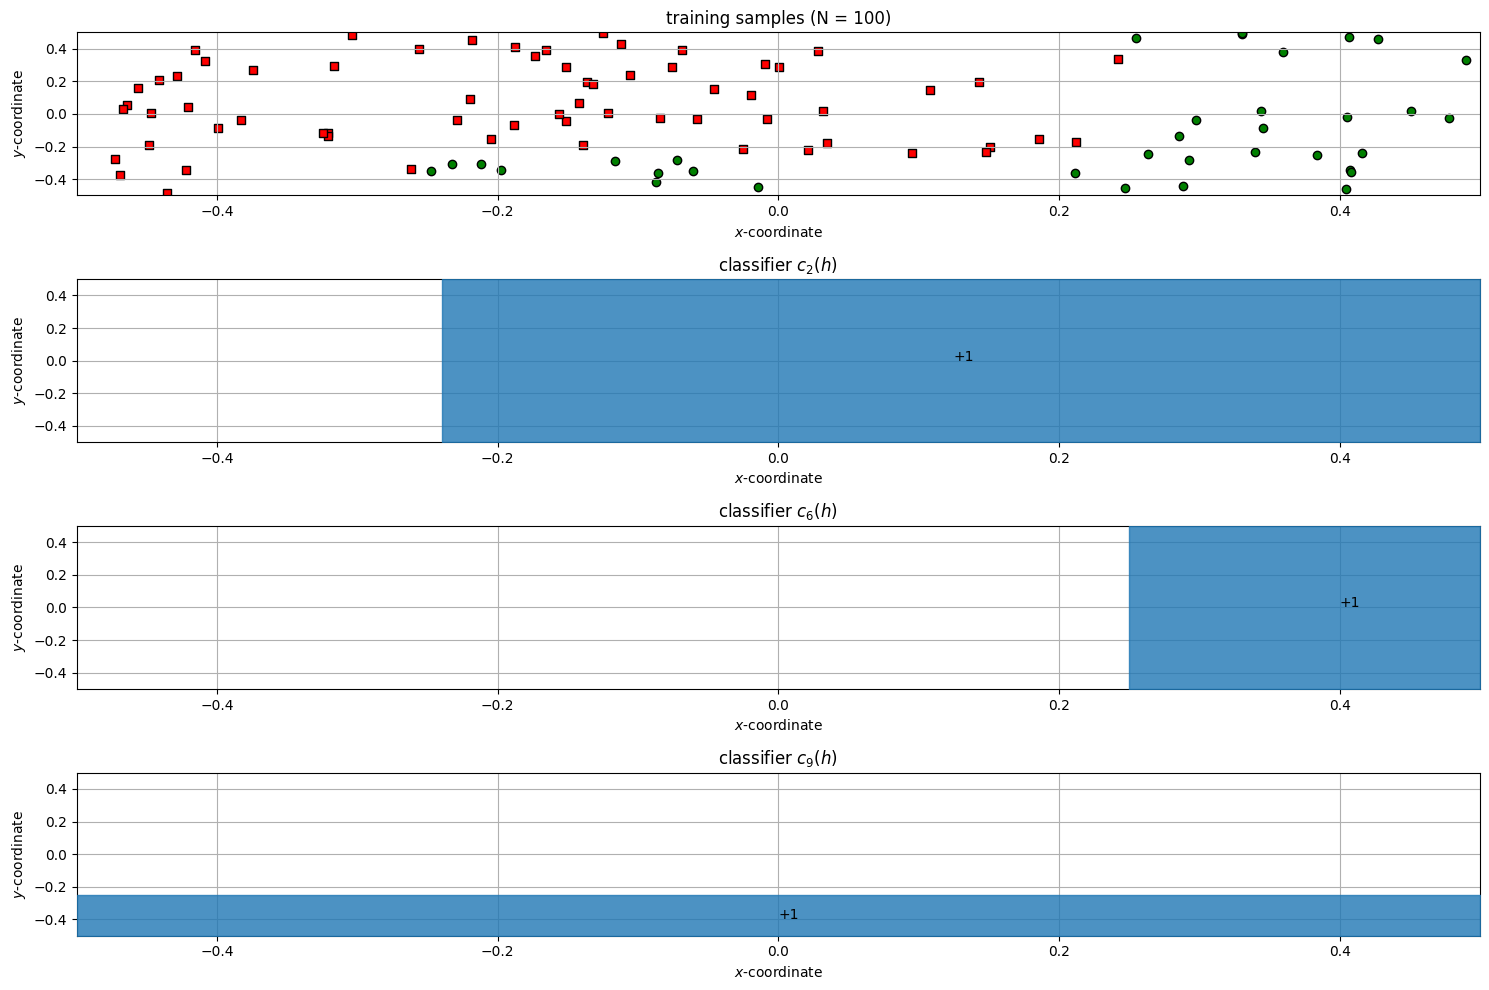

In [34]:
# figure 4 (AdaBoost classifier)

f = plt.figure(figsize=(15,10))

ax = f.add_subplot(4, 1, 1)
ax.scatter(xtg, ytg, c = 'green', edgecolors='black', marker='o')
ax.scatter(xtr, ytr, c = 'red', edgecolors='black', marker='s')
ax.set_ylabel('$y$-coordinate')
ax.set_xlabel('$x$-coordinate')
ax.grid()
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_title('training samples (N = 100)');

ax = f.add_subplot(4, 1, 2)
ax.fill_between(x=[-0.24, 0.5], y1=[-0.5, -0.5], y2=[0.5, 0.5], zorder=3, color="tab:blue", alpha=0.8)
ax.grid(zorder=0)
ax.set_ylim([-0.5, 0.5])
ax.set_xlim([-0.5, 0.5])
ax.set_ylabel('$y$-coordinate')
ax.set_xlabel('$x$-coordinate')
ax.set_title("classifier $c_2(h)$")
ax.annotate("+1", xy=(0.125, 0))

ax = f.add_subplot(4, 1, 3)
ax.fill_between(x=[0.25, 0.5], y1=[-0.5, -0.5], y2=[0.5, 0.5], zorder=3, color="tab:blue", alpha=0.8)
ax.grid(zorder=0)
ax.set_ylim([-0.5, 0.5])
ax.set_xlim([-0.5, 0.5])
ax.set_ylabel('$y$-coordinate')
ax.set_xlabel('$x$-coordinate')
ax.set_title("classifier $c_6(h)$")
ax.annotate("+1", xy=(0.4, 0))

ax = f.add_subplot(4, 1, 4)
ax.fill_between(x=[-0.5, 0.5], y1=[-0.25, -0.25], y2=[-0.5, -0.5], zorder=3, color="tab:blue", alpha=0.8)
ax.grid(zorder=0)
ax.set_ylim([-0.5, 0.5])
ax.set_xlim([-0.5, 0.5])
ax.set_ylabel('$y$-coordinate')
ax.set_xlabel('$x$-coordinate')
ax.set_title("classifier $c_9(h)$")
ax.annotate("+1", xy=(0, -0.4))

f.tight_layout()

plt.savefig('figs/fig 62.5.pdf')

**Figure 62.5** The top plot shows the $N=100$ training feature vectors. The bottom three plots show the discrimination regions for the three classifiers $\{c_2(h),c_6(h),c_9(h)\}$ that were selected by the boosting procedure. The colored areas indicate the regions that correspond to class $+1$ for each classifier; the regions corresponding to class $-1$ are left uncolored. 